##### Copyright 2025 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK and the client

### Install SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

You'll find more details about the SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [2]:
%pip install -q -U "google-genai>=1.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 8.7 MB/s eta 0:00:00


### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [3]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Select model and initialize SDK client

The client will pick up your API key from the environment variable.

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

In [4]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL_ID = "gemini-2.5-flash" # @param ["gemini-2.5-flash-lite","gemini-2.5-flash","gemini-2.5-pro","gemini-2.0-flash"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [5]:
from IPython.display import HTML, Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What was the latest Indian Premier League match and who won?',
    config={"tools": [{"google_search": {}}]},
)

# print the response
display(Markdown(f"Response:\n {response.text}"))
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")

display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response:
 The latest Indian Premier League (IPL) match was the final of the IPL 2025 season, which took place on June 3, 2025.

The Royal Challengers Bengaluru (RCB) won their maiden IPL title by defeating the Punjab Kings (PBKS) by 6 runs in a thrilling final held at the Narendra Modi Stadium in Ahmedabad. Virat Kohli of RCB was the top scorer for his team in the final with 43 runs. Krunal Pandya was named Man of the Match for his economical bowling.

Search Query: ['latest Indian Premier League match and winner', 'IPL 2025 final match and winner']
Search Pages: olympics.com, thehindu.com, economictimes.com, wikipedia.org, skysports.com, olympics.com, wikipedia.org


The information provided may be outdated, as it is based on a knowledge cutoff. For the most current and authoritative details, please refer to the official [Model documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro), which includes the latest knowledge cutoff date.

You can see that running the same prompt without search grounding gives you outdated information:

In [6]:
from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What was the latest Indian Premier League match and who won?',
)

# print the response
display(Markdown(response.text))

The latest Indian Premier League match was the **final of the IPL 2024 season**, played on **May 26, 2024**.

It was contested between:
*   **Kolkata Knight Riders (KKR)**
*   **Sunrisers Hyderabad (SRH)**

**Kolkata Knight Riders (KKR) won the match by 8 wickets**, securing their third IPL title.

## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [7]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [8]:
chat = client.chats.create(model=MODEL_ID)

response = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')

show_parts(response)

The most recent game between Australia and Chinese Taipei was in **basketball**.

*   **FIBA Asia Cup Qualifiers**
*   **Date:** February 25, 2024
*   **Result:** **Australia** defeated Chinese Taipei 90-58.

They also played recently in **soccer (football)**:

*   **FIFA World Cup Qualifier**
*   **Date:** October 12, 2023
*   **Result:** **Australia** defeated Chinese Taipei 5-0.

Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [9]:
search_tool = {'google_search': {}}

soccer_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')

show_parts(response)

The most recent games between Australia and Chinese Taipei have seen varying results across different sports.

In **women's futsal**, Chinese Taipei secured a 1-0 victory over Australia in their final game of the AFC Women's Futsal Asian Cup on May 10, 2025.

In **baseball**, Chinese Taipei defeated Australia with a score of 11-3 in the WBSC Premier12 on November 17, 2024.

In **women's soccer**, Australia triumphed over Chinese Taipei with a 3-1 win in an international friendly on December 4, 2024.

In **men's volleyball**, Australia defeated Chinese Taipei 3-1 in the AVC Men's Nations Cup on June 22, 2025.

In **women's volleyball**, Chinese Taipei won 3-0 against Australia in the AVC Nations Cup Women on June 7, 2025.

In **men's basketball**, Australia defeated Chinese Taipei 90-71 in a FIBA Asia Qualifier game on February 24, 2022.

In **women's U18 basketball**, Australia secured a 90-67 victory against Chinese Taipei in the FIBA U18 Women's Asia Cup on June 26, 2024.

As you are using a `chat` session, you can ask the model follow-up questions too.

In [10]:
response = soccer_chat.send_message('Who scored the goals?')

show_parts(response)

In the most recent games between Australia and Chinese Taipei where goals were scored:

**Women's Soccer - December 4, 2024 (Australia 3-1 Chinese Taipei):**
For Australia, the goals were scored by Tash Prior, Sharn Freier, and Bryleeh Henry.
Chinese Taipei's lone goal was scored by Chen Jin-Wen.

**Women's Futsal - May 10, 2025 (Chinese Taipei 1-0 Australia):**
The sole goal for Chinese Taipei was scored by Liu Chih-Ling.

## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [11]:
movie_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = movie_chat.send_message('Generate some Python code to plot the runtimes of the 10 more recent Denis Villeneuve movies.')

show_parts(response)

Denis Villeneuve's filmography showcases a diverse range of cinematic works, with his more recent films tending towards longer runtimes, particularly within the science fiction genre. Here are the 10 most recent feature films directed by Denis Villeneuve, along with their runtimes:

*   **Dune: Part Two** (2024): 166 minutes
*   **Dune** (2021): 155 minutes
*   **Blade Runner 2049** (2017): 163 minutes
*   **Arrival** (2016): 116 minutes
*   **Sicario** (2015): 121 minutes
*   **Prisoners** (2013): 153 minutes
*   **Enemy** (2013): 91 minutes
*   **Incendies** (2010): 131 minutes
*   **Polytechnique** (2009): 77 minutes
*   **Maelström** (2000): 87 minutes

Here's Python code to plot the runtimes of these movies:



```python
import matplotlib.pyplot as plt
import numpy as np

# Data for Denis Villeneuve's 10 most recent movies and their runtimes
movies = [
    "Dune: Part Two (2024)",
    "Dune (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Prisoners (2013)",
    "Enemy (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Maelström (2000)"
]

runtimes = [166, 155, 163, 116, 121, 153, 91, 131, 77, 87] # Runtimes in minutes

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 7)) # Adjust figure size for better readability
bars = ax.bar(movies, runtimes, color='skyblue')

# Add titles and labels
ax.set_xlabel("Movie Title (Release Year)", fontsize=12)
ax.set_ylabel("Runtime (Minutes)", fontsize=12)
ax.set_title("Runtimes of Denis Villeneuve's 10 Most Recent Movies", fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Add the runtime values on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval), ha='center', va='bottom', fontsize=9)

# Improve layout and display the plot
plt.tight_layout()
plt.show()
```

First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

import matplotlib.pyplot as plt
import numpy as np

# Data for Denis Villeneuve's 10 most recent movies and their runtimes
movies = [
    "Dune: Part Two (2024)",
    "Dune (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Prisoners (2013)",
    "Enemy (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Maelström (2000)"
]

runtimes = [166, 155, 163, 116, 121, 153, 91, 131, 77, 87] # Runtimes in minutes

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 7)) # Adjust figure size for better readability
bars = ax.bar(movies, runtimes, color='skyblue')

# Add titles and labels
ax.set_xlabel("Movie Title (Release Year)", fontsize=12)
ax.set_ylabel("Runtime (Minutes)", fontsize=12)
ax.set_title("Runtimes of Denis Villeneuve's 10 Most Recent Movies", fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Add the runtime values on top of the bars
for bar in bars:
    yval = bar.get_height(

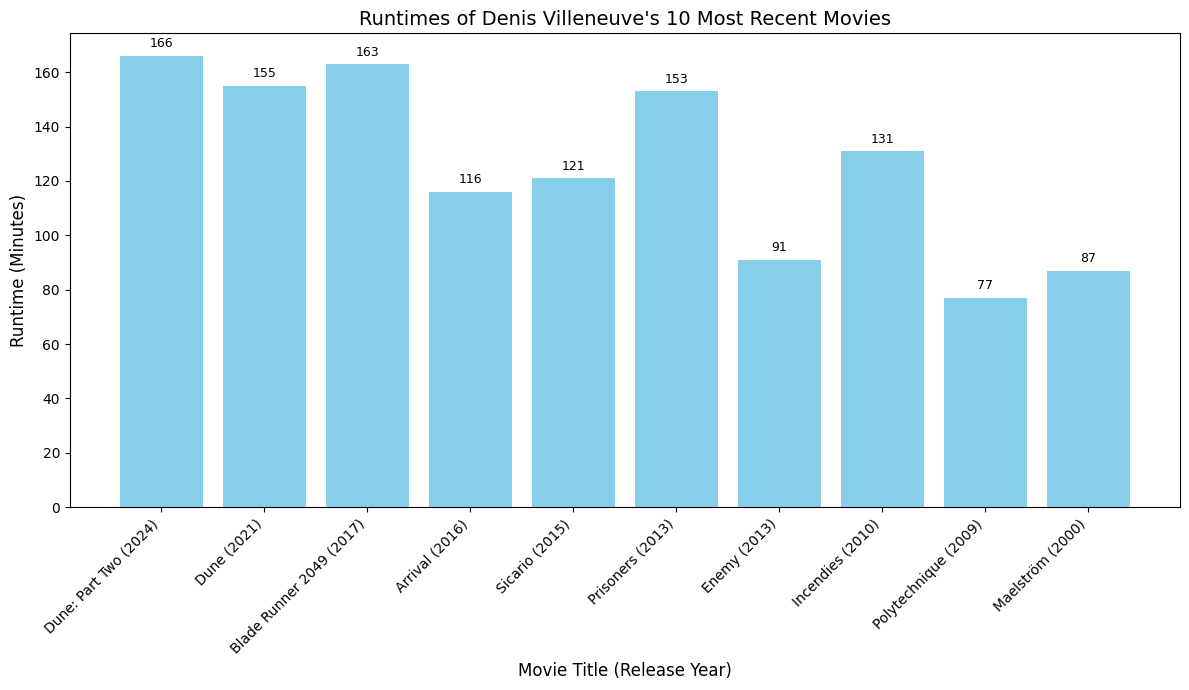

In [12]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)
print(matchFound.group(1))
if matchFound:
  code = matchFound.group(1)
  exec(code)

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [13]:
response = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')

show_parts(response)

To give the chart a dark theme, we can utilize Matplotlib's built-in `dark_background` style. This style automatically adjusts the background, text, and other elements for a dark aesthetic.

Here's the modified Python code:



```python
import matplotlib.pyplot as plt
import numpy as np

# Data for Denis Villeneuve's 10 most recent movies and their runtimes
movies = [
    "Dune: Part Two (2024)",
    "Dune (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Prisoners (2013)",
    "Enemy (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Maelström (2000)"
]

runtimes = [166, 155, 163, 116, 121, 153, 91, 131, 77, 87] # Runtimes in minutes

# Apply the dark background style
plt.style.use('dark_background') # [2, 4, 5]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 7)) # Adjust figure size for better readability
bars = ax.bar(movies, runtimes, color='skyblue') # Skyblue works well against dark background

# Add titles and labels
ax.set_xlabel("Movie Title (Release Year)", fontsize=12, color='white')
ax.set_ylabel("Runtime (Minutes)", fontsize=12, color='white')
ax.set_title("Runtimes of Denis Villeneuve's 10 Most Recent Movies", fontsize=14, color='white')
plt.xticks(rotation=45, ha='right', color='white') # Rotate x-axis labels for better readability
plt.yticks(color='white') # Set y-axis tick label color

# Add the runtime values on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval), ha='center', va='bottom', fontsize=9, color='white')

# Improve layout and display the plot
plt.tight_layout()
plt.show()
```



By adding `plt.style.use('dark_background')`, the plot's background becomes dark, and the text and axes elements automatically adjust to a lighter color for better readability. I've also explicitly set the color of the labels and title to white for clarity, although `dark_background` often handles this default.

Again, always be sure to review code generated by the model before running it.

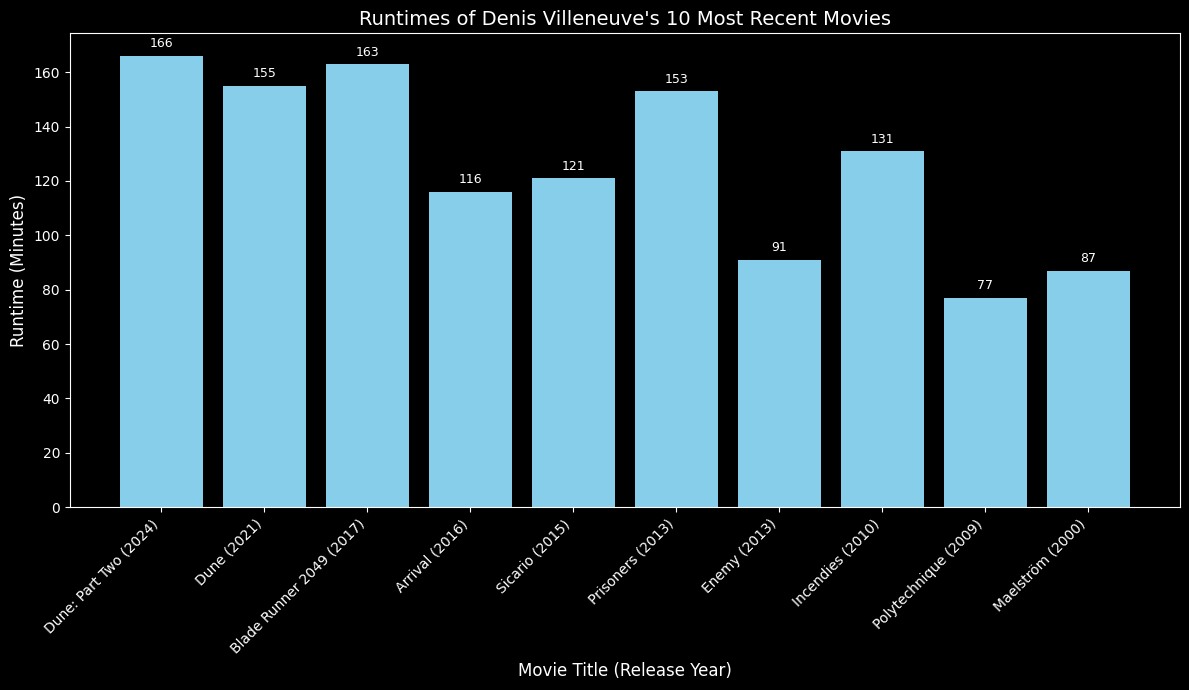

In [14]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)

if matchFound:
  code = matchFound.group(1)
  exec(code)

## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [15]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL_ID = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [16]:
# @title Helper functions for the Live API (run this cell)

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL_ID, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [17]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

/tmp/ipython-input-4150174230.py:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.......

.......

.......

......

.......

.......

.....

.......

.......

...


Now re-run with the Search tool enabled.

In [18]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

/tmp/ipython-input-4150174230.py:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

..

.......

.......

.......

.......

.......

.......

.....


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [22]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [30]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris using search and set my climate control appropriately. I trust your judgement, so just do it.", tools)

/tmp/ipython-input-4150174230.py:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

..

/tmp/ipython-input-4150174230.py:55: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await stream.send(input=tool_response)


.Tool call..

.......

.......

.......


Now inspect the `tool_call` response(s) you received during the conversation.

In [31]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

set_climate(mode=cold, strength=7)  # id=function-call-8243969279664206973


## Next steps

<a name="next_steps"></a>

Search grounding is not the only way to ground your requests, you can also use Youtube links and URL context. Check the [Grounding](./Grounding.ipynb) guide for more info on those capabilities.

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini advanced capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).